In [7]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
import pandas as pd
from IPython.display import display
from matplotlib import rcParams

def run_algorithm(lambda_, delta, n_rounds, noise_variance):
    # Initialize
    d = 10
    V0 = lambda_ * np.eye(d)
    theta0 = np.zeros(d)

    # theta* from a multivariable Gaussian distribution
    mu = np.zeros(d)  # mean = 0
    sigma = np.eye(d)  # covariance matrix = I
    theta_star = np.random.multivariate_normal(mu, sigma)

    # 1. decision set
    def generate_decision_set(d, num_actions=1000):
        actions = np.random.randn(num_actions, d)
        actions = actions / np.linalg.norm(actions, axis=1, keepdims=True)  # unit ball
        return actions

    # 2. regularized least-squares estimate
    def compute_theta(V, actions, rewards):
        return np.linalg.inv(V).dot(actions.T.dot(rewards))

    # 3. confidence set
    def construct_confidence_set(theta, V, beta):
        return theta, beta * np.linalg.inv(V)  # ellipsoid

    # 4. UCB computation
    def compute_ucb(actions, theta, invV, beta):
        ucb_values = []
        for a in actions:
            ucb_value = theta.dot(a) + beta * np.sqrt(a.T.dot(invV).dot(a))
            ucb_values.append(ucb_value)
        return np.array(ucb_values)

    # compute beta_t (confidence bound parameter)
    def compute_beta_t(t, d, lambda_, delta=0.001):
        return np.sqrt(lambda_) + np.sqrt(
            2 * np.log(1 / delta) + d * np.log((1 + t / (lambda_ * d)))
        )

    # Run the algorithm for n rounds
    actions_list = []
    rewards_list = []
    total_possible_reward = 0
    total_reward = 0
    regrets = []
    distances = []

    for t in range(1, n_rounds + 1):
        At = generate_decision_set(d)
        if t == 1:
            Vt = V0
            theta_t = theta0
        else:
            Vt = V0 + np.dot(np.array(actions_list).T, np.array(actions_list))
            theta_t = compute_theta(Vt, np.array(actions_list), np.array(rewards_list))
        invVt = np.linalg.inv(Vt)
        beta_t = compute_beta_t(t, d, lambda_, delta)
        confidence_set_center, confidence_set_matrix = construct_confidence_set(
            theta_t, Vt, beta_t
        )
        ucb_values = compute_ucb(At, confidence_set_center, invVt, beta_t)
        # 5. select action with highest UCB
        At_selected = At[np.argmax(ucb_values)]
        # 6. simulate observe reward
        Xt = At_selected.dot(theta_star) + np.random.randn() * np.sqrt(noise_variance)  # add Gaussian noise

        # optimal reward
        optimal_reward = max(At.dot(theta_star))
        total_possible_reward += optimal_reward
        total_reward += Xt
        regret = optimal_reward - Xt
        regrets.append(regret)
        #Print to check each round's results
        # print(f"Round {t}")
        # print(f"  Selected action: {At_selected}")
        # print(f"  Observed reward: {Xt}")
        # print(f"  Instantaneous regret: {regret}\n")

        # Calculate distance to true theta
        distance = np.linalg.norm(theta_t - theta_star)
        distances.append(distance)

        # 7. Update history
        actions_list.append(At_selected)
        rewards_list.append(Xt)

    # Compute cumulative regret and regret per trial
    cumulative_regret = np.cumsum(regrets)
    regret_per_trial = cumulative_regret / np.arange(1, n_rounds + 1)

    return regret_per_trial, cumulative_regret, distances

/var/folders/kc/21bq4tj54yd85cvbhqmsw58r0000gn/T/ipykernel_14863/191652096.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


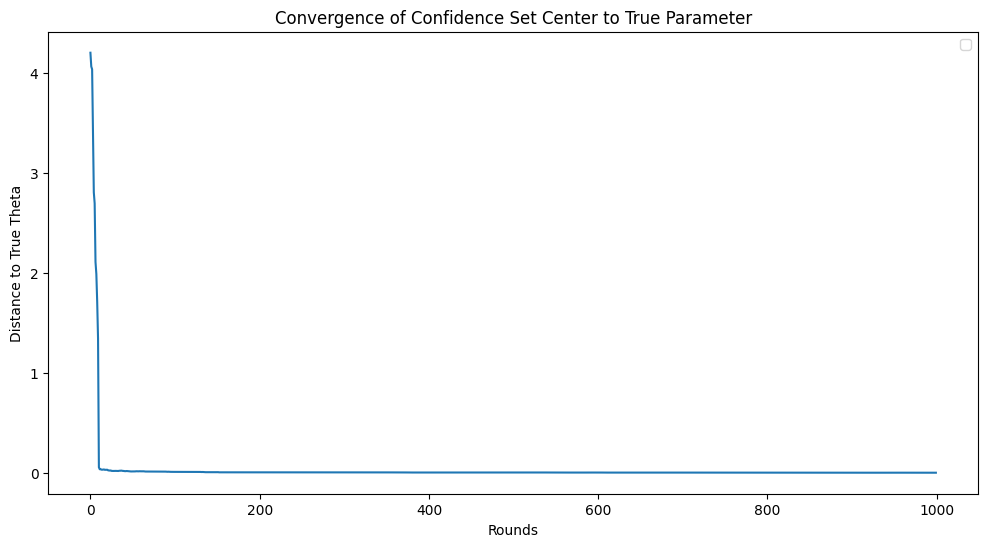

In [10]:

#average
lambda_ = 0.01
delta = 0.0001
n_rounds = 1000
noise_variance = 0.0001

regret_per_trial, cumulative_regret, distances = run_algorithm (lambda_, delta, n_rounds, noise_variance)


# Plot the distances to see convergence
plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.xlabel('Rounds')
plt.ylabel('Distance to True Theta')
plt.title('Convergence of Confidence Set Center to True Parameter')
plt.legend()
plt.show()

/var/folders/kc/21bq4tj54yd85cvbhqmsw58r0000gn/T/ipykernel_3082/232403395.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=16)


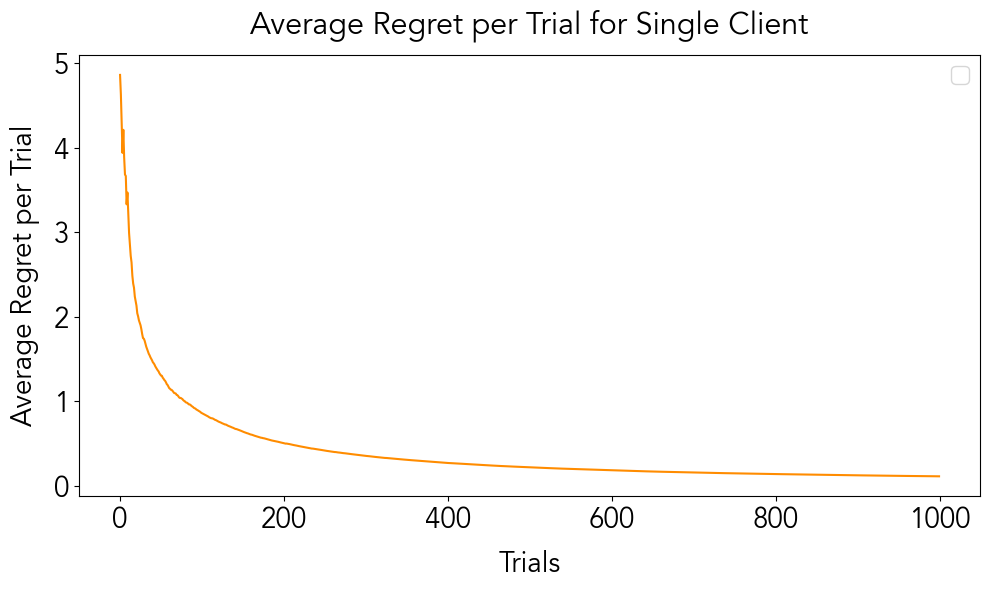

/var/folders/kc/21bq4tj54yd85cvbhqmsw58r0000gn/T/ipykernel_3082/232403395.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=16)


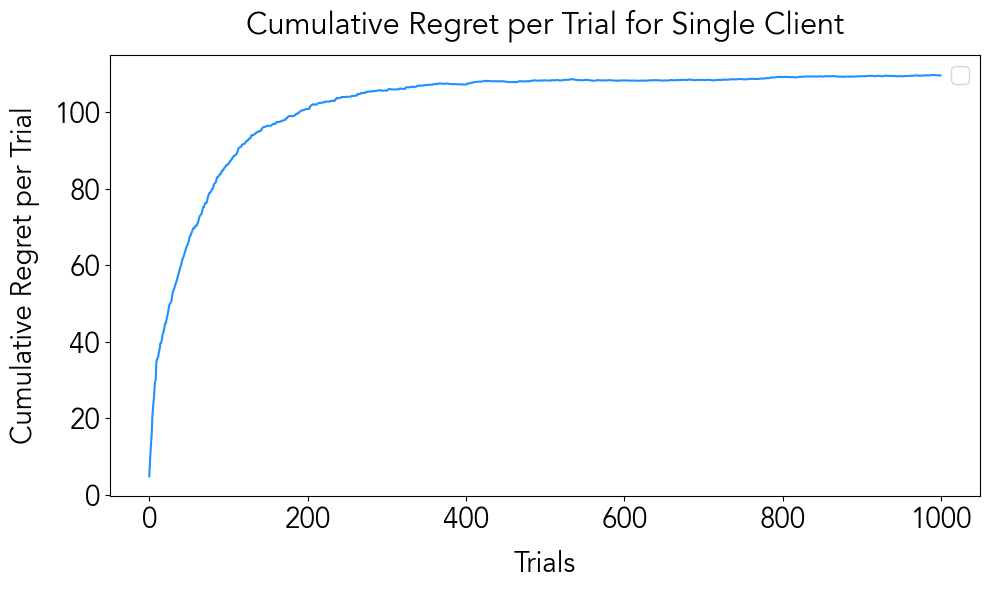

In [16]:
# Parameters
lambda_ = 0.01
delta = 0.0001
n_rounds = 1000
noise_variance = 0.001
n_runs = 1

# # Run the algorithm multiple times and average the results
# all_regrets = np.zeros((n_runs, n_rounds))

# for i in range(n_runs):
#     all_regrets[i] = run_algorithm(lambda_, delta, n_rounds, noise_variance)

regret_per_trial, cumulative_regret = run_algorithm(lambda_, delta, n_rounds, noise_variance)

# average_regret_per_trial = np.mean(all_regrets, axis=0)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Avenir'  # Replace with a more common font
plt.rcParams['font.monospace'] = 'Avenir Mono'
#Plot the average regret per trial
plt.figure(figsize=(10, 6))
plt.plot(regret_per_trial, color='darkorange')
plt.xlabel('Trials', fontsize=20, labelpad=10)
plt.ylabel('Average Regret per Trial', fontsize=20, labelpad=10)
plt.title('Average Regret per Trial for Single Client', pad = 15, fontsize=22)
plt.legend(fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

#cumulative regret
plt.figure(figsize=(10, 6))
plt.plot(cumulative_regret, color='dodgerblue')
plt.xlabel('Trials', fontsize=20, labelpad=10)
plt.ylabel('Cumulative Regret per Trial', fontsize=20, labelpad=10)
plt.title('Cumulative Regret per Trial for Single Client', pad = 15, fontsize=22)
plt.legend(fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()

In [6]:
# Parameters
lambda_ = 0.01
delta = 0.0001
n_rounds = 1000
noise_variance = 0.001
n_runs = 1

regret_per_trial, cumulative_regret = run_algorithm(lambda_, delta, n_rounds, noise_variance)
# Select intervals for displaying regrets
interval = 10
iterations = list(range(1, n_rounds + 1, interval))

# Create a DataFrame to display results at each interval for each client
data_per_trial = {
    'Iteration': list(range(1, n_rounds + 1)),
    'Regret per Trial': regret_per_trial,
}
df_per_trial = pd.DataFrame(data_per_trial)

# Display the DataFrame
print(df_per_trial)

     Iteration  Regret per Trial
0            1          2.269144
1            2          2.298486
2            3          2.568990
3            4          2.263431
4            5          2.128424
..         ...               ...
995        996          0.180807
996        997          0.180673
997        998          0.180529
998        999          0.180385
999       1000          0.180180

[1000 rows x 2 columns]


/var/folders/kc/21bq4tj54yd85cvbhqmsw58r0000gn/T/ipykernel_67555/1593434926.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


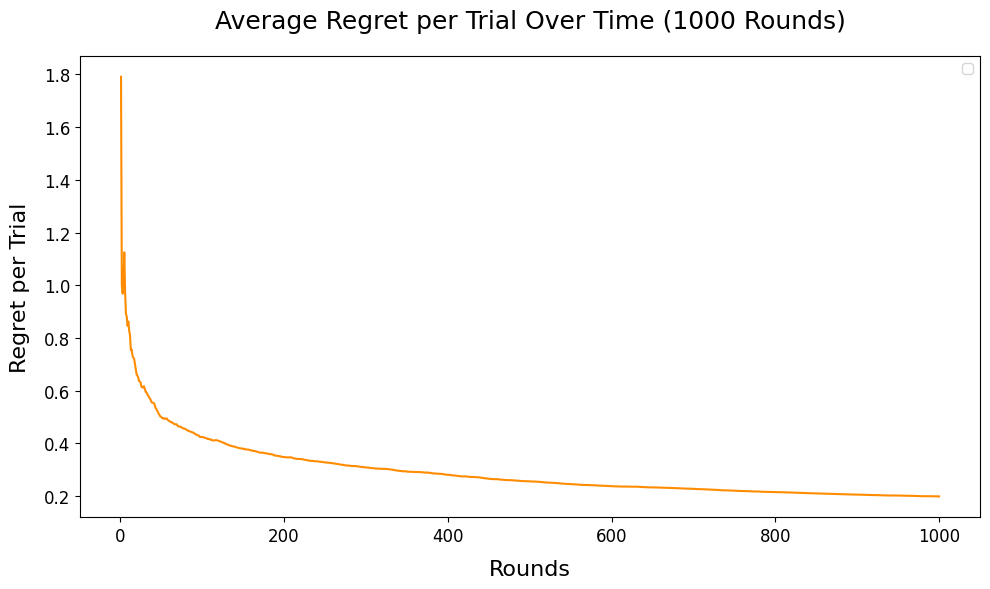

In [9]:
#simple regret over time plot
lambda_ = 0.01
delta = 0.0001
n_rounds = 1000
noise_variance = 0.01
regret_per_trial = run_algorithm(lambda_, delta, n_rounds, noise_variance)
#cumulative_regret = np.cumsum(regret_per_trial)
# Plot 
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_rounds + 1), regret_per_trial, color='darkorange')
plt.xlabel('Rounds', fontsize=16, labelpad=10)
plt.ylabel('Regret per Trial', fontsize=16, labelpad=10)
plt.title('Average Regret per Trial Over Time (1000 Rounds)', fontsize=18, pad =20 )
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

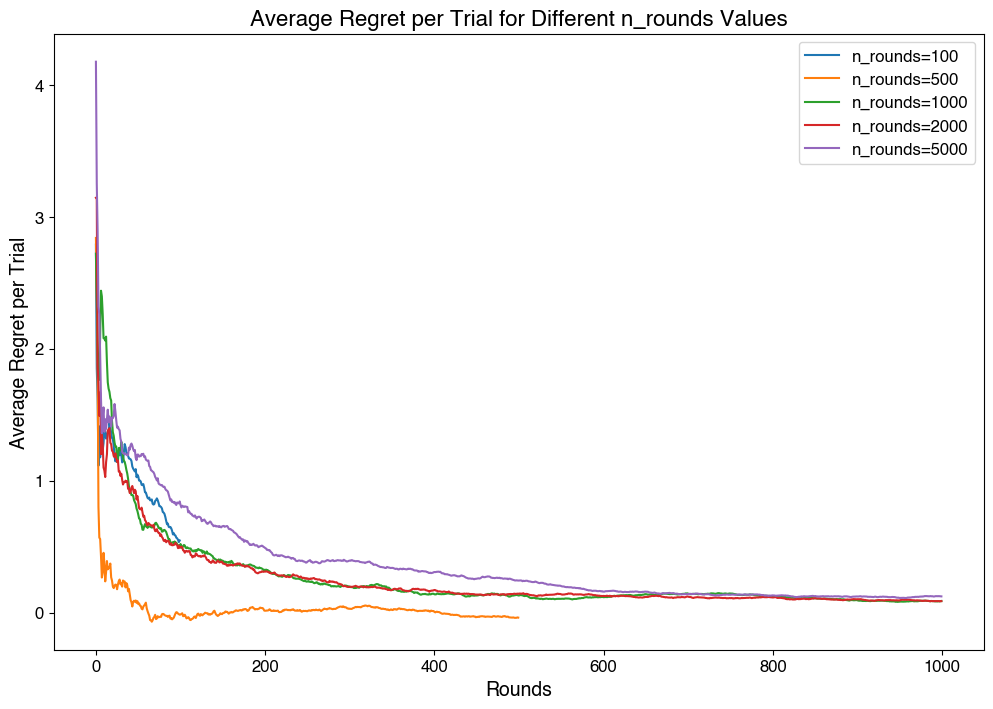

In [47]:
# Define a smaller range of n_rounds values
n_rounds_values = [100, 500, 1000, 2000, 5000]

# Run the algorithm for different n_rounds values
results = {n: run_algorithm(1, 0.01, n, 1) for n in n_rounds_values}

# Plot the average regret per trial
plt.figure(figsize=(12, 8))
for n_rounds in n_rounds_values:
    average_regret = results[n_rounds]
    max_points = min(1000, len(average_regret))  # Plot up to the first 1000 points to avoid large image sizes
    plt.plot(average_regret[:max_points], label=f'n_rounds={n_rounds}')
plt.xlabel('Rounds', fontsize=14)
plt.ylabel('Average Regret per Trial', fontsize=14)
plt.title('Average Regret per Trial for Different n_rounds Values', fontsize=16)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [70]:
# Parameters
noise_variance = 0.1
n_rounds = 100
lambda_ = 0.01
delta = 0.0001
regrets = run_algorithm(lambda_, delta, n_rounds, noise_variance)
cumulative_regret = np.cumsum(regrets)
interval = 10
iterations = list(range(1, n_rounds + 1, interval))
regrets_at_intervals = regrets[interval-1::interval]

cumulative_regret_at_intervals = cumulative_regret[interval-1::interval]

# Create a DataFrame to display results at each interval
data = {
    'Iteration': iterations,
    'Regret': regrets_at_intervals,
   'Cumulative Regret': cumulative_regret_at_intervals,
  #  'Regret Per Trial': regret_per_trial_at_intervals
}
df = pd.DataFrame(data)

# Display the DataFrame
display(df)

,Iteration,Regret,Cumulative Regret
0,1,2.542704,21.882316
1,11,0.670950,27.881485
2,21,1.238497,34.043163
3,31,0.390963,37.368504
4,41,0.808165,42.012290
5,51,0.125463,44.099665
6,61,0.778545,47.068044
7,71,0.363243,49.330513
8,81,0.552833,52.607900
9,91,0.441060,53.060688


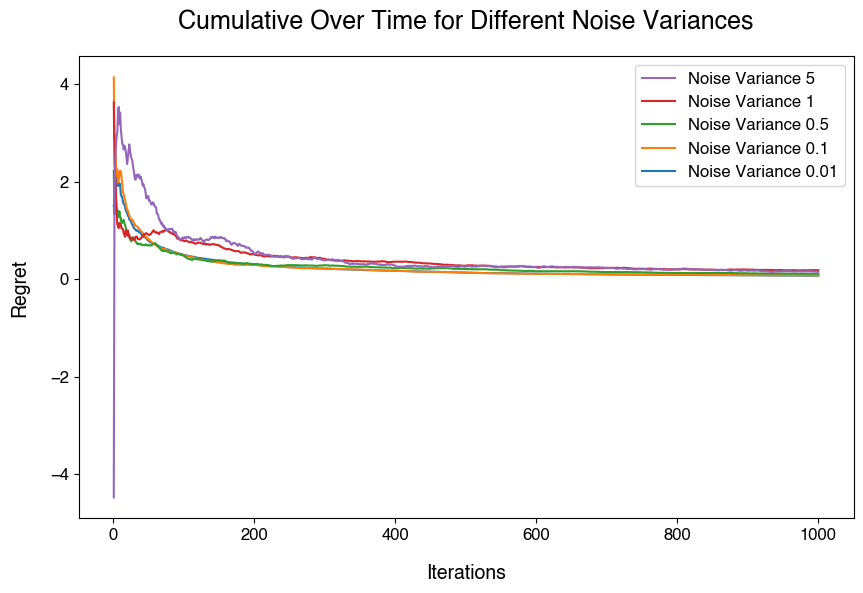

,Iteration,Noise Variance 0.01,Noise Variance 0.1,Noise Variance 0.5,Noise Variance 1,Noise Variance 5
0,1,1.497347,4.135282,2.218425,3.623084,-4.479596
1,101,0.496158,0.485717,0.467763,0.773247,0.853976
2,201,0.296887,0.289195,0.308687,0.496599,0.506144
3,301,0.214059,0.216760,0.283623,0.409609,0.392773
4,401,0.168136,0.169846,0.222289,0.355983,0.262672
5,501,0.131482,0.131235,0.203795,0.276310,0.261198
6,601,0.109742,0.107608,0.160609,0.245528,0.236351
7,701,0.094683,0.099116,0.144434,0.227835,0.231299
8,801,0.082683,0.089653,0.126222,0.197380,0.206017
9,901,0.076344,0.080742,0.118228,0.192718,0.173464


In [46]:
noise_variances = [0.01, 0.1, 0.5, 1, 5]
# Number of rounds
n_rounds = 1000

# Run for each noise variances
regret_per_trial_dict = {}
for noise_variance in noise_variances:
    regret_per_trial_dict[noise_variance] = run_algorithm(0.01, 0.0001, n_rounds, noise_variance)

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.size'] = 12

# Plotting the regret per trial over time for different noise variances
plt.figure(figsize=(10, 6))
for noise_variance in noise_variances:
    plt.plot(range(1, n_rounds + 1), regret_per_trial_dict[noise_variance], label=f'Noise Variance {noise_variance}')
plt.xlabel('Iterations', fontsize=14, labelpad=15)
plt.ylabel('Regret', fontsize=14, labelpad=15)
plt.title('Cumulative Over Time for Different Noise Variances', pad=20, fontsize=18)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])
plt.show()

# Create a table to see if the regret decreases per iteration
interval = 100  # Interval at which to check the regret per iteration
table_data = {'Iteration': range(1, n_rounds + 1, interval)}

for noise_variance in noise_variances:
    table_data[f'Noise Variance {noise_variance}'] = [regret_per_trial_dict[noise_variance][i] for i in range(0, n_rounds, interval)]

# Create a DataFrame and display it
regret_table = pd.DataFrame(table_data)
display(regret_table)

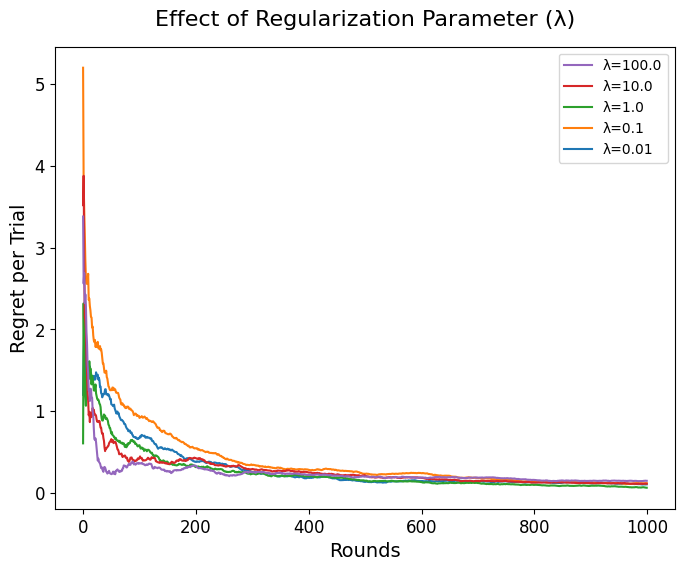

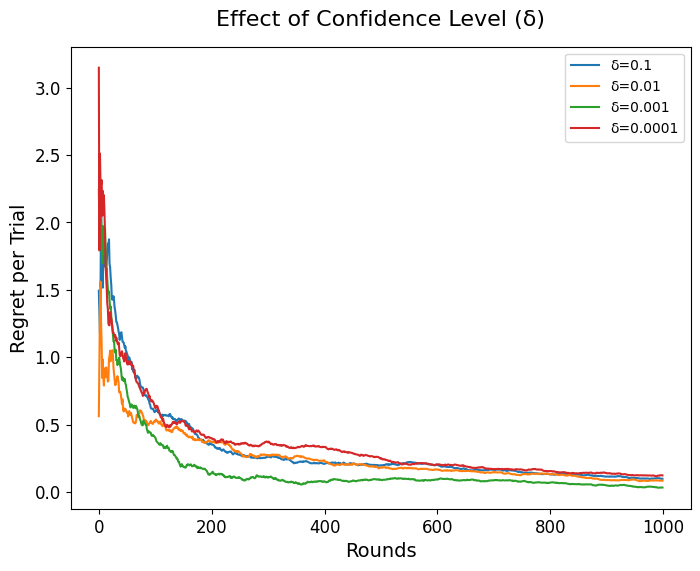

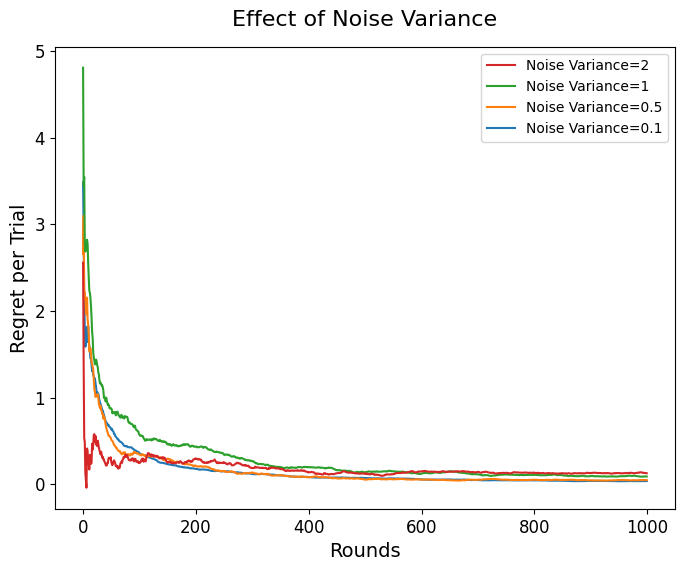

In [9]:
import matplotlib.pyplot as plt

# Define the parameter ranges
lambda_values = np.logspace(-2, 2, 5)
delta_values = [0.1, 0.01, 0.001, 0.0001]
noise_variances = [0.1, 0.5, 1, 2]
n_rounds = 1000

# Placeholder data for demonstration purposes
regret_per_trial_lambda = [run_algorithm(lambda_, 0.01, n_rounds, 1) for lambda_ in lambda_values]
regret_per_trial_delta = [run_algorithm(1, delta, n_rounds, 1) for delta in delta_values]
regret_per_trial_noise = [run_algorithm(1, 0.01, n_rounds, noise) for noise in noise_variances]

# Plot the effect of lambda
plt.figure(figsize=(8, 6))
for i, lambda_ in enumerate(lambda_values):
    plt.plot(regret_per_trial_lambda[i], label=f'λ={lambda_}')
plt.xlabel('Rounds', fontsize=14)
plt.ylabel('Regret per Trial', fontsize=14)
plt.title('Effect of Regularization Parameter (λ)', fontsize=16, pad = 15)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Plot the effect of delta
plt.figure(figsize=(8, 6))
for i, delta in enumerate(delta_values):
    plt.plot(regret_per_trial_delta[i], label=f'δ={delta}')
plt.xlabel('Rounds', fontsize=14)
plt.ylabel('Regret per Trial', fontsize=14)
plt.title('Effect of Confidence Level (δ)', fontsize=16, pad = 15)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Plot the effect of noise variance
plt.figure(figsize=(8, 6))
for i, noise in enumerate(noise_variances):
    plt.plot(regret_per_trial_noise[i], label=f'Noise Variance={noise}')
plt.xlabel('Rounds', fontsize=14)
plt.ylabel('Regret per Trial', fontsize=14)
plt.title('Effect of Noise Variance', fontsize=16, pad = 15)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()